# Identify Alleles with Cell Count Differences

In [1]:
# Imports
import os
import warnings
import numpy as np
import polars as pl
from tqdm import tqdm
import statsmodels.formula.api as smf
from scipy.stats import ttest_rel

PLATEMAP_DIR = "../../../8.2_updated_snakemake_pipeline/inputs/metadata/platemaps/{batch_id}/platemap"
PROF_DIR = "../../../8.2_updated_snakemake_pipeline/outputs/batch_profiles"
CLASS_RES_DIR = "../../../8.2_updated_snakemake_pipeline/outputs/classification_results"

BIO_REP_BATCHES = ["2024_01_23_Batch_7", "2024_02_06_Batch_8"]
COMBINED_BIO_REP_DIR = "2024_02_Batch_7-8"

# BIO_REP_BATCHES = ["2025_01_27_Batch_13", "2025_01_28_Batch_14"]
# COMBINED_BIO_REP_DIR = "2025_01_Batch_13-14"

# BIO_REP_BATCHES = ["2025_03_17_Batch_15", "2025_03_17_Batch_16"]
# COMBINED_BIO_REP_DIR = "2025_03_Batch_15-16"

OUTPUT_DIR = f"../../outputs/{COMBINED_BIO_REP_DIR}"
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

## 1. Summarize Cell Count Profiles

### 1.1 Allele Metadata

In [2]:
batch_id = BIO_REP_BATCHES[0]
allele_meta_df = pl.DataFrame()

for platemap in os.listdir(PLATEMAP_DIR.format(batch_id=batch_id)):
    platemap_df = pl.read_csv(os.path.join(PLATEMAP_DIR.format(batch_id=batch_id), platemap), separator="\t", infer_schema_length=100000)
    allele_meta_df = pl.concat([allele_meta_df, platemap_df], how="diagonal_relaxed")

allele_meta_df

plate_map_name,well_position,control_type,symbol,gene_allele,imaging_well,imaging_plate_R1,imaging_plate_R2,node_type,orf_id_wt,ccsb_mutation_id,nt_change_cdna,aa_change,allele_set,imaging_plate,batch1,batch2,clone_ID,hgmd_ID,clinvar_allele_ID,clinvar_clinical_significance,vector,notes,plate,quad,c96,r96,r384,c384,r384_letter,gene_symbol,symbol_original
str,str,str,str,str,str,str,str,str,f64,f64,str,str,f64,i64,i64,i64,str,str,str,str,f64,str,i64,i64,i64,i64,i64,i64,str,str,str
"""B7A1R1_P1""","""A01""","""disease_wt""","""ACSF3""","""ACSF3""","""A01""","""B7A1R1_P1""","""B8A1R2_P1""","""disease_wt""",71337.0,null,null,null,1.0,1,7,8,null,null,null,null,527.0,null,1,1,1,1,1,1,"""A""","""ACSF3""","""ACSF3"""
"""B7A1R1_P1""","""C01""","""allele""","""ACSF3""","""ACSF3_Ala197Thr""","""C01""","""B7A1R1_P1""","""B8A1R2_P1""","""allele""",71337.0,3943.0,"""589G>A""","""Ala197Thr""",1.0,1,7,8,null,null,null,null,527.0,null,1,1,1,2,3,1,"""C""","""ACSF3""","""ACSF3"""
"""B7A1R1_P1""","""E01""","""allele""","""ACSF3""","""ACSF3_Thr358Ile""","""E01""","""B7A1R1_P1""","""B8A1R2_P1""","""allele""",71337.0,205771.0,"""1073C>T""","""Thr358Ile""",1.0,1,7,8,null,null,null,null,527.0,null,1,1,1,3,5,1,"""E""","""ACSF3""","""ACSF3"""
"""B7A1R1_P1""","""G01""","""allele""","""ACSF3""","""ACSF3_Met198Arg""","""G01""","""B7A1R1_P1""","""B8A1R2_P1""","""allele""",71337.0,3944.0,"""593T>G""","""Met198Arg""",1.0,1,7,8,null,null,null,null,527.0,null,1,1,1,4,7,1,"""G""","""ACSF3""","""ACSF3"""
"""B7A1R1_P1""","""I01""","""allele""","""ACSF3""","""ACSF3_Glu359Lys""","""I01""","""B7A1R1_P1""","""B8A1R2_P1""","""allele""",71337.0,205770.0,"""1075G>A""","""Glu359Lys""",1.0,1,7,8,null,null,null,null,527.0,null,1,1,1,5,9,1,"""I""","""ACSF3""","""ACSF3"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""B7A1R1_P2""","""H24""","""disease_wt""","""MAP2K2""","""MAP2K2""","""H24""","""B7A1R1_P2""","""B8A1R2_P2""","""disease_wt""",6666.0,null,null,null,1.0,2,7,8,null,null,null,null,527.0,null,2,4,12,4,8,24,"""H""","""MAP2K2""","""MAP2K2"""
"""B7A1R1_P2""","""J24""","""allele""","""MAP2K2""","""MAP2K2_Thr17Ala""","""J24""","""B7A1R1_P2""","""B8A1R2_P2""","""allele""",6666.0,51.0,"""49A>G""","""Thr17Ala""",1.0,2,7,8,null,null,null,null,527.0,null,2,4,12,5,10,24,"""J""","""MAP2K2""","""MAP2K2"""
"""B7A1R1_P2""","""L24""","""disease_wt""","""MAX""","""MAX""","""L24""","""B7A1R1_P2""","""B8A1R2_P2""","""disease_wt""",4384.0,null,null,null,1.0,2,7,8,null,null,null,null,527.0,null,2,4,12,6,12,24,"""L""","""MAX""","""MAX"""


In [5]:
allele_meta_df.filter((pl.col("gene_allele").is_not_null())&(pl.col("node_type")=="allele")).unique(subset=["gene_allele"])
# allele_meta_df.filter(pl.col("node_type")=="allele")["gene_allele"].unique()

plate_map_name,well_position,control_type,symbol,gene_allele,imaging_well,imaging_plate_R1,imaging_plate_R2,node_type,orf_id_wt,ccsb_mutation_id,nt_change_cdna,aa_change,allele_set,imaging_plate,batch1,batch2,clone_ID,hgmd_ID,clinvar_allele_ID,clinvar_clinical_significance,vector,notes,plate,quad,c96,r96,r384,c384,r384_letter,gene_symbol,symbol_original
str,str,str,str,str,str,str,str,str,f64,f64,str,str,f64,i64,i64,i64,str,str,str,str,f64,str,i64,i64,i64,i64,i64,i64,str,str,str
"""B7A1R1_P2""","""P08""","""allele""","""KRT8""","""KRT8_Gly434Ser""","""P08""","""B7A1R1_P2""","""B8A1R2_P2""","""allele""",14966.0,218521.0,"""1300G>A""","""Gly434Ser""",1.0,2,7,8,null,null,null,null,527.0,null,2,4,4,8,16,8,"""P""","""KRT8""","""KRT8"""
"""B7A1R1_P2""","""N17""","""allele""","""KCTD1""","""KCTD1_Gly62Asp""","""N17""","""B7A1R1_P2""","""B8A1R2_P2""","""allele""",14221.0,218283.0,"""185G>A""","""Gly62Asp""",1.0,2,7,8,null,null,null,null,527.0,null,2,3,9,7,14,17,"""N""","""KCTD1""","""KCTD1"""
"""B7A1R1_P2""","""B04""","""allele""","""KRT6A""","""KRT6A_Asn171Ser""","""B04""","""B7A1R1_P2""","""B8A1R2_P2""","""allele""",4870.0,215270.0,"""512A>G""","""Asn171Ser""",1.0,2,7,8,null,null,null,null,527.0,null,2,4,2,1,2,4,"""B""","""KRT6A""","""KRT6A"""
"""B7A1R1_P4""","""E13""","""allele""","""SMAD3""","""SMAD3_Tyr364Cys""","""E13""","""B7A1R1_P4""","""B8A1R2_P4""","""allele""",11805.0,2172.0,"""1091A>G""","""Tyr364Cys""",1.0,4,7,8,null,null,null,null,527.0,null,4,1,7,3,5,13,"""E""","""SMAD3""","""SMAD3"""
"""B7A1R1_P4""","""G11""","""allele""","""SMAD3""","""SMAD3_Leu274Pro""","""G11""","""B7A1R1_P4""","""B8A1R2_P4""","""allele""",11805.0,2155.0,"""821T>C""","""Leu274Pro""",1.0,4,7,8,null,null,null,null,527.0,null,4,1,6,4,7,11,"""G""","""SMAD3""","""SMAD3"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""B7A1R1_P4""","""C04""","""allele""","""STXBP1""","""STXBP1_Pro94Leu""","""C04""","""B7A1R1_P4""","""B8A1R2_P4""","""allele""",7652.0,1794.0,"""281C>T""","""Pro94Leu""",1.0,4,7,8,null,null,null,null,527.0,null,4,2,2,2,3,4,"""C""","""STXBP1""","""STXBP1"""
"""B7A1R1_P4""","""B10""","""allele""","""TEAD2""","""TEAD2_Pro213Ser""","""B10""","""B7A1R1_P4""","""B8A1R2_P4""","""allele""",null,null,null,"""Pro213Ser""",1.0,4,7,8,null,null,null,null,527.0,null,4,4,5,1,2,10,"""B""","""TEAD2""","""TEAD2"""
"""B7A1R1_P4""","""H03""","""allele""","""TPM1""","""TPM1_Ile172Thr""","""H03""","""B7A1R1_P4""","""B8A1R2_P4""","""allele""",4723.0,201740.0,"""515T>C""","""Ile172Thr""",1.0,4,7,8,null,null,null,null,527.0,null,4,3,2,4,8,3,"""H""","""TPM1""","""TPM1"""


In [ ]:
# allele_meta_df.filter(pl.col("gene_allele").str.contains("FBP1"))

plate_map_name,well_position,control_type,symbol,gene_allele,imaging_well,imaging_plate_R1,imaging_plate_R2,node_type,orf_id_wt,ccsb_mutation_id,nt_change_cdna,aa_change,allele_set,imaging_plate,batch1,batch2,clone_ID,hgmd_ID,clinvar_allele_ID,clinvar_clinical_significance,vector,notes,plate,quad,c96,r96,r384,c384,r384_letter,gene_symbol,symbol_original
str,str,str,str,str,str,str,str,str,f64,f64,str,str,f64,i64,i64,i64,str,str,str,str,f64,str,i64,i64,i64,i64,i64,i64,str,str,str
"""B7A1R1_P1""","""N24""","""disease_wt""","""FBP1""","""FBP1""","""N24""","""B7A1R1_P1""","""B8A1R2_P1""","""disease_wt""",2654.0,null,null,null,1.0,1,7,8,null,null,null,null,527.0,null,1,4,12,7,14,24,"""N""","""FBP1""","""FBP1"""
"""B7A1R1_P1""","""P24""","""allele""","""FBP1""","""FBP1_Ala177Asp""","""P24""","""B7A1R1_P1""","""B8A1R2_P1""","""allele""",2654.0,214307.0,"""530C>A""","""Ala177Asp""",1.0,1,7,8,null,null,null,null,527.0,null,1,4,12,8,16,24,"""P""","""FBP1""","""FBP1"""
"""B7A1R1_P2""","""A01""","""disease_wt""","""FBP1""","""FBP1""","""A01""","""B7A1R1_P2""","""B8A1R2_P2""","""disease_wt""",2654.0,null,null,null,1.0,2,7,8,null,null,null,null,527.0,null,2,1,1,1,1,1,"""A""","""FBP1""","""FBP1"""
"""B7A1R1_P2""","""C01""","""allele""","""FBP1""","""FBP1_Pro284Arg""","""C01""","""B7A1R1_P2""","""B8A1R2_P2""","""allele""",2654.0,214309.0,"""851C>G""","""Pro284Arg""",1.0,2,7,8,null,null,null,null,527.0,null,2,1,1,2,3,1,"""C""","""FBP1""","""FBP1"""
"""B7A1R1_P2""","""E01""","""allele""","""FBP1""","""FBP1_Met289Leu""","""E01""","""B7A1R1_P2""","""B8A1R2_P2""","""allele""",2654.0,460.0,"""865A>T""","""Met289Leu""",1.0,2,7,8,null,null,null,null,527.0,null,2,1,1,3,5,1,"""E""","""FBP1""","""FBP1"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""B7A1R1_P2""","""K01""","""allele""","""FBP1""","""FBP1_Phe233Ile""","""K01""","""B7A1R1_P2""","""B8A1R2_P2""","""allele""",2654.0,900209.0,"""697T>A""","""Phe233Ile""",1.0,2,7,8,null,null,null,null,527.0,null,2,1,1,6,11,1,"""K""","""FBP1""","""FBP1"""
"""B7A1R1_P2""","""M01""","""allele""","""FBP1""","""FBP1_Gly164Ser""","""M01""","""B7A1R1_P2""","""B8A1R2_P2""","""allele""",2654.0,4167.0,"""490G>A""","""Gly164Ser""",1.0,2,7,8,null,null,null,null,527.0,null,2,1,1,7,13,1,"""M""","""FBP1""","""FBP1"""
"""B7A1R1_P2""","""O01""","""allele""","""FBP1""","""FBP1_Phe194Ser""","""O01""","""B7A1R1_P2""","""B8A1R2_P2""","""allele""",2654.0,4169.0,"""581T>C""","""Phe194Ser""",1.0,2,7,8,null,null,null,null,527.0,null,2,1,1,8,15,1,"""O""","""FBP1""","""FBP1"""


In [6]:
combined_profiles = pl.DataFrame()
for batch_id in BIO_REP_BATCHES:
    # Get meta features
    batch_alleles = (
        pl.scan_parquet(
            f"{PROF_DIR}/{batch_id}/profiles_tcdropped_filtered_var_mad_outlier_featselect_filtcells.parquet"
        )
        .select([
            "Metadata_gene_allele",
            "Metadata_Well",
            "Metadata_Plate",
        ])
    )
    combined_profiles = pl.concat([combined_profiles, batch_alleles.collect()])

## Get the cell count per allele in each well
well_profiles = combined_profiles.group_by([
    "Metadata_Well", "Metadata_Plate", "Metadata_gene_allele"
]).len().rename({"len": "Cell_count"})

In [44]:
well_profiles.filter(pl.col("Metadata_gene_allele").str.contains("_")).unique(subset="Metadata_gene_allele")

Metadata_Well,Metadata_Plate,Metadata_gene_allele,Cell_count
str,str,str,u32
"""M04""","""2024_01_17_B7A1R1_P1T3""","""APOA1_Leu198Ser""",195
"""A17""","""2024_02_02_B8A1R2_P3T1""","""MVK_Arg388Gln""",72
"""J18""","""2024_01_19_B7A1R1_P3T4""","""RP2_Arg282Trp""",390
"""K08""","""2024_01_17_B7A1R1_P1T3""","""ASNS_Ala6Glu""",380
"""E14""","""2024_01_22_B7A1R1_P4T3""","""TH_Arg306His""",230
…,…,…,…
"""I17""","""2024_01_31_B8A1R2_P1T4""","""AGXT_Arg381Lys""",120
"""J08""","""2024_01_17_B7A1R1_P1T3""","""DES_Pro433Thr""",351
"""K02""","""2024_01_18_B7A1R1_P3T1""","""NCF2_Asp108Val""",63


In [ ]:
batch_log_files = [
    f"{CLASS_RES_DIR}/{batch_id}/profiles_tcdropped_filtered_var_mad_outlier_featselect_filtcells/classify.log" \
    for batch_id in BIO_REP_BATCHES
]

dropped_well_df = pl.DataFrame()
for logfile in batch_log_files:
    with open(logfile, encoding="latin-1") as f:
        lines = f.readlines()
    dropped_wells = [(l.split(",")[0].strip(), l.split(",")[1].strip()) for l in lines if l.startswith("2024")]
    dropped_well_df = pl.concat([dropped_well_df, 
                                 pl.DataFrame({"plate": [well[0] for well in dropped_wells],
                                               "imaging_well": [well[1].split(":")[0] for well in dropped_wells],
                                               "gene_allele": [well[1].split(":")[1] for well in dropped_wells]})])
# dropped_well_df.unique(subset="gene_allele")["gene_allele"]

## 2. Cell Count Change Detection

In [57]:
from scipy.stats import shapiro
import re
from scipy.stats import wilcoxon
from scipy.stats import ttest_rel
import pandas as pd


# Convert letter rows to numbers
def well_to_coordinates(well):
    row_letter, col_number = re.match(r"([A-P])(\d{2})", well).groups()
    row_index = ord(row_letter) - ord('A') + 1  # Convert 'A'->1, 'B'->2, ..., 'P'->16
    col_index = int(col_number)  # Convert string column to integer
    return well, row_index, col_index


# Compute distances from edges and find the most centered well
def compute_distance(row, col):
    return min(row - 1, 16 - row, col - 1, 24 - col)  # Distance from nearest edge
    

def paired_ttest(dat, reference: str, var: str):
    ## perform stat test
    ## sorted the two alleles to make sure they are from the same plate for paired t-test    
    # if (dat[dat["Metadata_gene_allele"]==reference].shape[0] != dat[dat["Metadata_gene_allele"]==var].shape[0]):
    # pivot to wide: one row per plate
    wide_cc = dat.pivot(index="Metadata_Plate",
                        columns="Metadata_gene_allele",
                        values="Cell_count")
    # drop any plate that doesn’t have both measurements
    wide_cc = wide_cc.dropna(subset=[reference, var])
    if wide_cc.shape[0] >= 3:
        # now run paired t-test
        t_stat, p_val = ttest_rel(wide_cc[reference], wide_cc[var])
    else:
        t_stat, p_val = None, None

    # df_sampled["PlateID"] = df_sampled["Metadata_Plate"].str.extract(r"(P\d+T\d+)", expand=False)
    dat["dist2edge"] = dat["Metadata_Well"].apply(lambda x: compute_distance(well_to_coordinates(x)[1], well_to_coordinates(x)[2]))
    # fit Cell_count ~ dist2edge
    m0 = smf.ols("Cell_count ~ dist2edge", data=dat).fit()
    dat["resid"] = m0.resid
    ## calc t-test on residuals corrected for distance to edge
    wide_res = dat.pivot(index="Metadata_Plate",
                        columns="Metadata_gene_allele",
                        values="resid")
    # drop any plate that doesn’t have both measurements
    wide_res = wide_res.dropna(subset=[reference, var])
    if wide_res.shape[0] >= 3:
        # now run paired t-test
        res_t_stat, res_p_val = ttest_rel(wide_res[reference], wide_res[var])
    else:
        res_t_stat, res_p_val = None, None
    
    summary_df = pl.DataFrame(
        {
            "t_stat": t_stat,
            "p_val": p_val,
            "t_stat_res": res_t_stat,
            "p_val_res": res_p_val
        }
    )
    summary_df = summary_df.with_columns(
        pl.lit(reference).alias("Gene"), pl.lit(var).alias("Variant")
    )
    return summary_df

### 2.1 Paired T-test

In [58]:
well_cc_stats = []

for allele in tqdm(well_profiles.select(pl.col("Metadata_gene_allele")).to_pandas()["Metadata_gene_allele"].unique()):
    if allele is None or allele.split("_")[0] == allele:
        continue

    reference = allele.split("_")[0]
    temp_prof = well_profiles.filter(
        (pl.col("Metadata_gene_allele") == allele) | (pl.col("Metadata_gene_allele") == reference)
    ).to_pandas()

    if (temp_prof["Metadata_gene_allele"].unique().shape[0] < 2):
        # print(temp_prof)
        continue

    var_profiles = temp_prof[temp_prof["Metadata_gene_allele"]==allele]
    ref_profiles = temp_prof[(temp_prof["Metadata_gene_allele"]==reference)&(temp_prof["Metadata_Plate"].isin(var_profiles["Metadata_Plate"].unique()))]
    temp_prof = pd.concat([var_profiles, ref_profiles])

    ## Select ONLY the wells most distant from the edge per each allele to minimize the well-position edge effects
    ## deprecated: let's compare every pair
    # if (ref_profiles.shape[0] > var_profiles.shape[0]):
    #     ref_al_wells = ref_profiles["Metadata_Well"].unique()
    #     well_coords = [well_to_coordinates(w) for w in set([ref_well_pl for ref_well_pl in ref_al_wells])]
    #     # Sort wells by max distance from edges (descending)
    #     most_centered_well = max(well_coords, key=lambda x: compute_distance(x[1], x[2]))[0]
    #     ref_profiles = temp_prof[(temp_prof["Metadata_gene_allele"]==reference)&(temp_prof["Metadata_Well"]==most_centered_well)]
    # if (ref_profiles.shape[0] < var_profiles.shape[0]):
    #     ref_al_wells = var_profiles["Metadata_Well"].unique()
    #     well_coords = [well_to_coordinates(w) for w in set([ref_well_pl for ref_well_pl in ref_al_wells])]
    #     # Sort wells by max distance from edges (descending)
    #     most_centered_well = max(well_coords, key=lambda x: compute_distance(x[1], x[2]))[0]
    #     var_profiles = temp_prof[(temp_prof["Metadata_gene_allele"]==allele)&(temp_prof["Metadata_Well"]==most_centered_well)]

    ref_wells = ref_profiles["Metadata_Well"].unique()
    var_wells = var_profiles["Metadata_Well"].unique()
    ref_var_pairs = [(ref_well, var_well) for ref_well in ref_wells for var_well in var_wells]
    
    ## Per each ref-var well pair on the SAME plate, train and test the classifier
    for ref_var in ref_var_pairs:
        ## sort the wells to make sure they are from the same plate
        df_sampled = temp_prof[temp_prof["Metadata_Well"].isin(ref_var)].dropna().sort_values(["Metadata_Plate","Metadata_gene_allele"])
        paired_t_res = paired_ttest(
            dat=df_sampled,
            reference=reference,
            var=allele
        ).with_columns(
            pl.lit(ref_var[0]).alias("Ref_well"),
            pl.lit(ref_var[1]).alias("Var_well")
        )
        well_cc_stats.append(
            paired_t_res
        )
        
well_cc_stats = pl.concat(well_cc_stats,  how="vertical")
well_cc_stats = well_cc_stats.rename({"t_stat": "U2OS_paired_t_stat", "p_val": "U2OS_t_pval", "t_stat_res": "U2OS_paired_tstat_res", "p_val_res": "U2OS_t_res_pval"})
well_cc_stats = well_cc_stats.select(["Gene", "Variant", "U2OS_paired_t_stat", "U2OS_t_pval", "Ref_well", "Var_well"])
well_cc_stats

100%|██████████| 1265/1265 [00:06<00:00, 207.09it/s]


Gene,Variant,U2OS_paired_t_stat,U2OS_t_pval,Ref_well,Var_well
str,str,f64,f64,str,str
"""PKP2""","""PKP2_Ile487Ser""",-1.335383,0.230177,"""K24""","""B01"""
"""STXBP1""","""STXBP1_Lys333Glu""",null,null,"""K21""","""G04"""
"""TH""","""TH_Val468Met""",2.04939,0.079602,"""I12""","""O14"""
"""GCK""","""GCK_Glu221Lys""",2.645751,0.033145,"""E13""","""C17"""
"""NEUROG3""","""NEUROG3_Arg107Ser""",-4.055885,0.006682,"""O04""","""A06"""
…,…,…,…,…,…
"""STAC3""","""STAC3_Trp245Ser""",2.316891,0.146445,"""K19""","""M19"""
"""PRKAR1A""","""PRKAR1A_Met1Val""",null,null,"""J04""","""P04"""
"""HPRT1""","""HPRT1_Pro176Leu""",2.04939,0.079602,"""C16""","""K20"""


In [59]:
well_cc_stats.write_csv(f"../../outputs/{COMBINED_BIO_REP_DIR}/well-level_cell-count_changes.csv")

### 2.2 LMM

In [11]:
# Correct p-values
from statsmodels.stats.multitest import multipletests

corrected = multipletests(well_cc_stats["P>|z|"].to_numpy(), method="fdr_bh")[1]
well_cc_stats = well_cc_stats.with_columns(pl.Series("FDR", corrected))

In [15]:
well_cc_stats

Coef.,Std.Err.,cc_Z,P>|z|,[0.025,0.975],Gene,Variant,FDR
f64,f64,f64,f64,f64,f64,str,str,f64
207.375,60.406,3.433,0.001,88.982,325.768,"""MSH2""","""MSH2_Asp167His""",0.003393
-89.125,61.964,-1.438,0.15,-210.571,32.321,"""RAD51D""","""RAD51D_Val28Leu""",0.239373
41.125,31.922,1.288,0.198,-21.441,103.691,"""RAF1""","""RAF1_Leu613Val""",0.296353
-45.25,33.485,-1.351,0.177,-110.879,20.379,"""ZC4H2""","""ZC4H2_Ile7Val""",0.271124
-50.375,74.415,-0.677,0.498,-196.226,95.476,"""G6PD""","""G6PD_Arg166Cys""",0.598646
…,…,…,…,…,…,…,…,…
36.875,53.681,0.687,0.492,-68.337,142.087,"""RAD51D""","""RAD51D_Ile17Val""",0.595763
-49.0,18.893,-2.594,0.009,-86.029,-11.971,"""F9""","""F9_Ala397Pro""",0.024683
131.333,67.275,1.952,0.051,-0.523,263.189,"""CCM2""","""CCM2_Gly407Asp""",0.106173


In [12]:
# Write out results
# well_cc_stats.write_csv(f"{metrics_dir}/well_cc_changes_plate_corrected.csv")

In [13]:
# Total number of increase vs. decrease
total = well_cc_stats.shape[0]
per_dec = well_cc_stats.filter(pl.col("cc_Z") < 0).shape[0]/total
per_inc = well_cc_stats.filter(pl.col("cc_Z") > 0).shape[0]/total

print("total increasing vs. decreasing percent")
print(per_dec)
print(per_inc)

dec_sig = well_cc_stats.filter(pl.col("FDR") < 0.05).filter(pl.col("cc_Z") < 0).shape[0]
inc_sig = well_cc_stats.filter(pl.col("FDR") < 0.05).filter(pl.col("cc_Z") > 0).shape[0]

print("Number sig decreases")
print(dec_sig)
print("Number sig increases")
print(inc_sig)

total increasing vs. decreasing percent
0.47161572052401746
0.5283842794759825
Number sig decreases
110
Number sig increases
77


/home/shenrunx/software/anaconda3/envs/varchamp/lib/python3.8/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 32'. Pick better value with 'binwidth'.


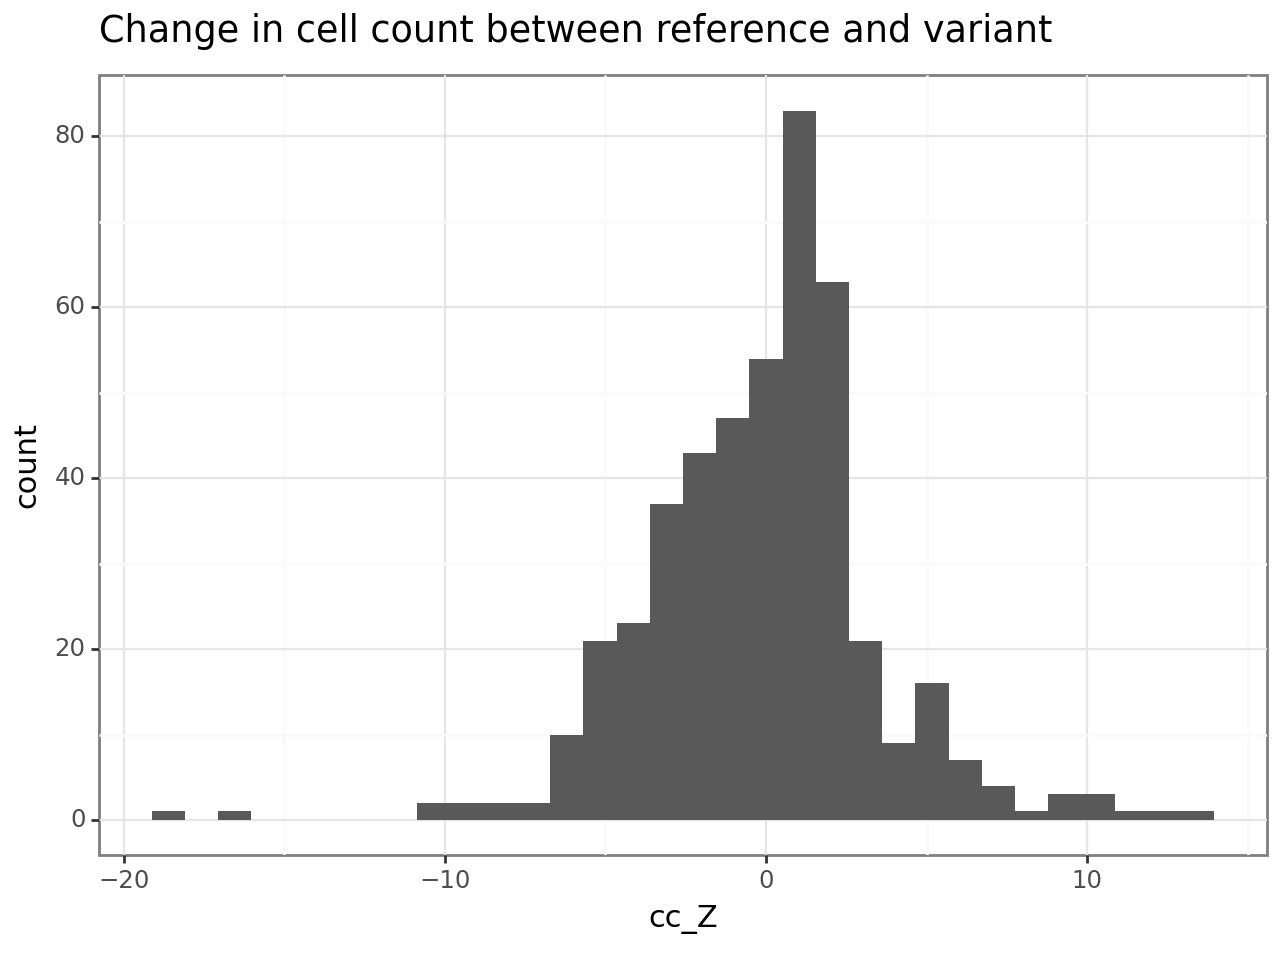

In [14]:
from plotnine import aes, geom_histogram, ggplot, theme_bw, labs
plot1 = (
    ggplot(
        well_cc_stats,
        aes(x="cc_Z"),
    )
    + geom_histogram()
    + theme_bw()
    + labs(title="Change in cell count between reference and variant")
)
print(plot1)

### No correction

In [20]:
well_abun_stats_no_corr = []
for allele in tqdm(misloc_alleles):
    temp_class = ind_class.filter(pl.col("allele_0") == allele)
    temp_prof = profiles.filter(
        (pl.col("Metadata_Plate").is_in(temp_class.select("Plate").to_series()))
        & (
            pl.col("Metadata_Well").is_in(temp_class.select("well_1"))
            | pl.col("Metadata_Well").is_in(temp_class.select("well_0"))
        )
    )
    well_abun_stats_no_corr.append(
        lmm(
            fix_var="Cell_count",
            reference=allele.split("_")[0],
            var=allele,
            dat=temp_prof.to_pandas().dropna(),
            rand_var=None
        )
    )

well_abun_stats_no_corr = pl.concat(well_abun_stats_no_corr, how="vertical")
well_abun_stats_no_corr = well_abun_stats_no_corr.rename({"t": "cc_t"})
well_abun_stats_no_corr.to_pandas().sort_values(by=["P>|t|","Coef."], ascending=[True, False])

## BH multiple test correction
corrected = multipletests(well_abun_stats_no_corr["P>|t|"].to_numpy(), method="fdr_bh")[1]
well_abun_stats_no_corr = well_abun_stats_no_corr.with_columns(pl.Series("FDR", corrected))

  0%|          | 0/458 [00:00<?, ?it/s]/home/shenrunx/software/anaconda3/envs/varchamp/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
/home/shenrunx/software/anaconda3/envs/varchamp/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
/home/shenrunx/software/anaconda3/envs/varchamp/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  1%|          | 3/458 [00:00<00:18, 23.97it/s]/home/shenrunx/software/anaconda3/envs/varchamp/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
/home/shenrunx/software/anaconda3/envs/varchamp/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
/hom

In [23]:
### Write out results
# well_abun_stats_no_corr.write_csv(f"{metrics_dir}/well_cc_changes_no_correction.csv")

# Total number of increase vs. decrease
total = well_abun_stats_no_corr.shape[0]
per_dec = well_abun_stats_no_corr.filter(pl.col("cc_t") < 0).shape[0]/total
per_inc = well_abun_stats_no_corr.filter(pl.col("cc_t") > 0).shape[0]/total

print("total increasing vs. decreasing percent")
print(per_dec)
print(per_inc)

dec_sig = well_abun_stats_no_corr.filter(pl.col("FDR") < 0.05).filter(pl.col("cc_t") < 0).shape[0]
inc_sig = well_abun_stats_no_corr.filter(pl.col("FDR") < 0.05).filter(pl.col("cc_t") > 0).shape[0]

print("Number sig decreases")
print(dec_sig)
print("Number sig increases")
print(inc_sig)

total increasing vs. decreasing percent
0.47161572052401746
0.5283842794759825
Number sig decreases
56
Number sig increases
51


In [40]:
well_abun_stats_no_corr

Coef.,Std.Err.,cc_t,P>|t|,[0.025,0.975],Gene,Variant,FDR
f64,f64,f64,f64,f64,f64,str,str,f64
207.375,60.405752,3.433034,0.004039,77.817547,336.932453,"""MSH2""","""MSH2_Asp167His""",0.024022
-89.125,61.963537,-1.438346,0.172314,-222.023569,43.773569,"""RAD51D""","""RAD51D_Val28Leu""",0.319344
41.125,50.79737,0.809589,0.431722,-67.824522,150.074522,"""RAF1""","""RAF1_Leu613Val""",0.57992
-45.25,49.118434,-0.921243,0.372527,-150.598563,60.098563,"""ZC4H2""","""ZC4H2_Ile7Val""",0.528227
-50.375,74.414905,-0.676948,0.509471,-209.979098,109.229098,"""G6PD""","""G6PD_Arg166Cys""",0.644579
…,…,…,…,…,…,…,…,…
36.875,53.680749,0.686932,0.503346,-78.258755,152.008755,"""RAD51D""","""RAD51D_Ile17Val""",0.641873
-49.0,48.273218,-1.015056,0.327301,-152.535755,54.535755,"""F9""","""F9_Ala397Pro""",0.49802
131.333333,67.274679,1.952196,0.060303,-6.05989,268.726557,"""CCM2""","""CCM2_Gly407Asp""",0.162463


### Compare cov. vs no-cov. models

In [60]:
from scipy import stats

def model_selector(fix_var: str, reference: str, var: str, dat, rand_var: str, alpha=0.05):
    """Systematic model selection workflow with diagnostics"""
    # Common formula setup
    formula = f"{fix_var} ~ C(Metadata_gene_allele, Treatment(reference='{reference}')) + C({rand_var})"
    
    # Fit both models
    full_model = smf.ols(
        formula=formula,
        data=dat,
        # groups=dat[rand_var],
        # re_formula="~1"
    ).fit() ## method='powell', reml=False
    
    # reduced_model = smf.ols(formula, dat).fit()

    print(full_model.summary())
    # print(reduced_model.summary())
    # Model comparison metrics
    # comparison = {
    #     "LRT_pvalue": stats.chi2.sf(2*(full_model.llf - reduced_model.llf), df=1),
    #     "AIC_diff": full_model.aic - reduced_model.aic,
    #     "BIC_diff": full_model.bic - reduced_model.bic,
    #     # "var_ratio": full_model.cov_re.iloc[0,0]/full_model.scale,
    #     # "converged": full_model.converged
    # }
    
    # Decision logic
    # if comparison["LRT_pvalue"] < alpha and comparison["var_ratio"] > 0.1:
    #     selected_model = full_model
    #     model_type = "mixedlm"
    # else:
    #     selected_model = reduced_model
    #     model_type = "ols"
    
    # return {
    #     # "selected_model": selected_model,
    #     "model_type": model_type,
    #     "diagnostics": comparison
    # }


# model = model_selector(
#     fix_var="Cell_count",
#     reference=allele.split("_")[0],
#     var=allele,
#     dat=temp_prof.to_pandas().dropna(),
#     rand_var="Metadata_Plate"
# )

2. Rationale & Key Components

* Likelihood Ratio Test (LRT):
    - Compares nested models using chi-square distribution (2Δlog-likelihood ~ χ²)
    - Significant p-value (<α) indicates better fit with random effects
    - Requires ML estimation (reml=False) for valid comparison
* Variance Ratio Check:
    - Calculates random_effect_variance/residual_variance
    - Ratio >0.1 suggests substantial between-group variation needing correction
    - Prevents overfitting trivial random effects
* Information Criteria:
    - AIC/BIC differences help assess model parsimony
    - Negative values favor mixed models despite complexity penalty
* Convergence Check:
    - Ensures mixed model results are reliable
    - Non-converged models should be discarded

In [65]:
well_abun_stats_compare = []
for allele in tqdm(misloc_alleles):
    try:
        temp_class = ind_class.filter(pl.col("allele_0") == allele)
        # display(temp_class)
        temp_prof = profiles.filter(
            (pl.col("Metadata_Plate").is_in(temp_class.select("Plate").to_series()))
            & (
                pl.col("Metadata_Well").is_in(temp_class.select("well_1"))
                | pl.col("Metadata_Well").is_in(temp_class.select("well_0"))
            )
        )
        display(temp_prof.to_pandas().dropna().sort_values(["Metadata_Plate","Metadata_gene_allele"]))
        break
        well_abun_stats_compare.append(
            model_selector(
                fix_var="Cell_count",
                reference=allele.split("_")[0],
                var=allele,
                dat=temp_prof.to_pandas().dropna(),
                rand_var="Metadata_Plate"
            )["diagnostics"]
        )
    except:
        continue

  0%|          | 0/461 [00:00<?, ?it/s]

,Metadata_Well,Metadata_Plate,Metadata_gene_allele,Cell_count
4,A01,2025_01_27_B13A7A8P2_T1,RAD51D,399
12,O01,2025_01_27_B13A7A8P2_T1,RAD51D_Ala231Ser,525
6,A01,2025_01_27_B13A7A8P2_T2,RAD51D,390
0,O01,2025_01_27_B13A7A8P2_T2,RAD51D_Ala231Ser,356
5,A01,2025_01_27_B13A7A8P2_T3,RAD51D,532
3,O01,2025_01_27_B13A7A8P2_T3,RAD51D_Ala231Ser,357
14,A01,2025_01_27_B13A7A8P2_T4,RAD51D,426
2,O01,2025_01_27_B13A7A8P2_T4,RAD51D_Ala231Ser,639
9,A01,2025_01_28_B14A7A8P2_T1,RAD51D,313
11,O01,2025_01_28_B14A7A8P2_T1,RAD51D_Ala231Ser,548


  0%|          | 0/461 [00:00<?, ?it/s]


In [54]:
import pandas as pd
well_abun_stats_compare_df = pd.DataFrame(well_abun_stats_compare)

In [57]:
# well_abun_stats_compare_df

In [39]:
import seaborn as sns
%matplotlib inline

# sns.displot(well_abun_stats_compare_df["LRT_pvalue"], binwidth=0.05)
# sns.displot(well_abun_stats_compare_df["AIC_diff"])
# sns.displot(well_abun_stats_compare_df["var_ratio"], binwidth=0.1)

## Analyze wrt Clinvar Annotations

In [3]:
cc_stats = pl.read_csv("../results/well_cc_changes.csv")

clinvar = pl.read_csv("../data/allele_collection_clinical_significance.csv")
clinvar = clinvar.with_columns(
    pl.concat_str(["symbol", "aa_change"], separator="_").alias("Variant")
).select(["Variant", "clinvar_cs"]).with_columns(
    pl.when(pl.col("clinvar_cs").is_not_null()).then("clinvar_cs").otherwise(pl.lit("not provided")).alias("clinvar_cs")
)

cc_stats = cc_stats.join(clinvar, on="Variant")

/dgx1nas1/storage/data/jess/miniforge3/envs/varchamp/lib/python3.8/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 18'. Pick better value with 'binwidth'.


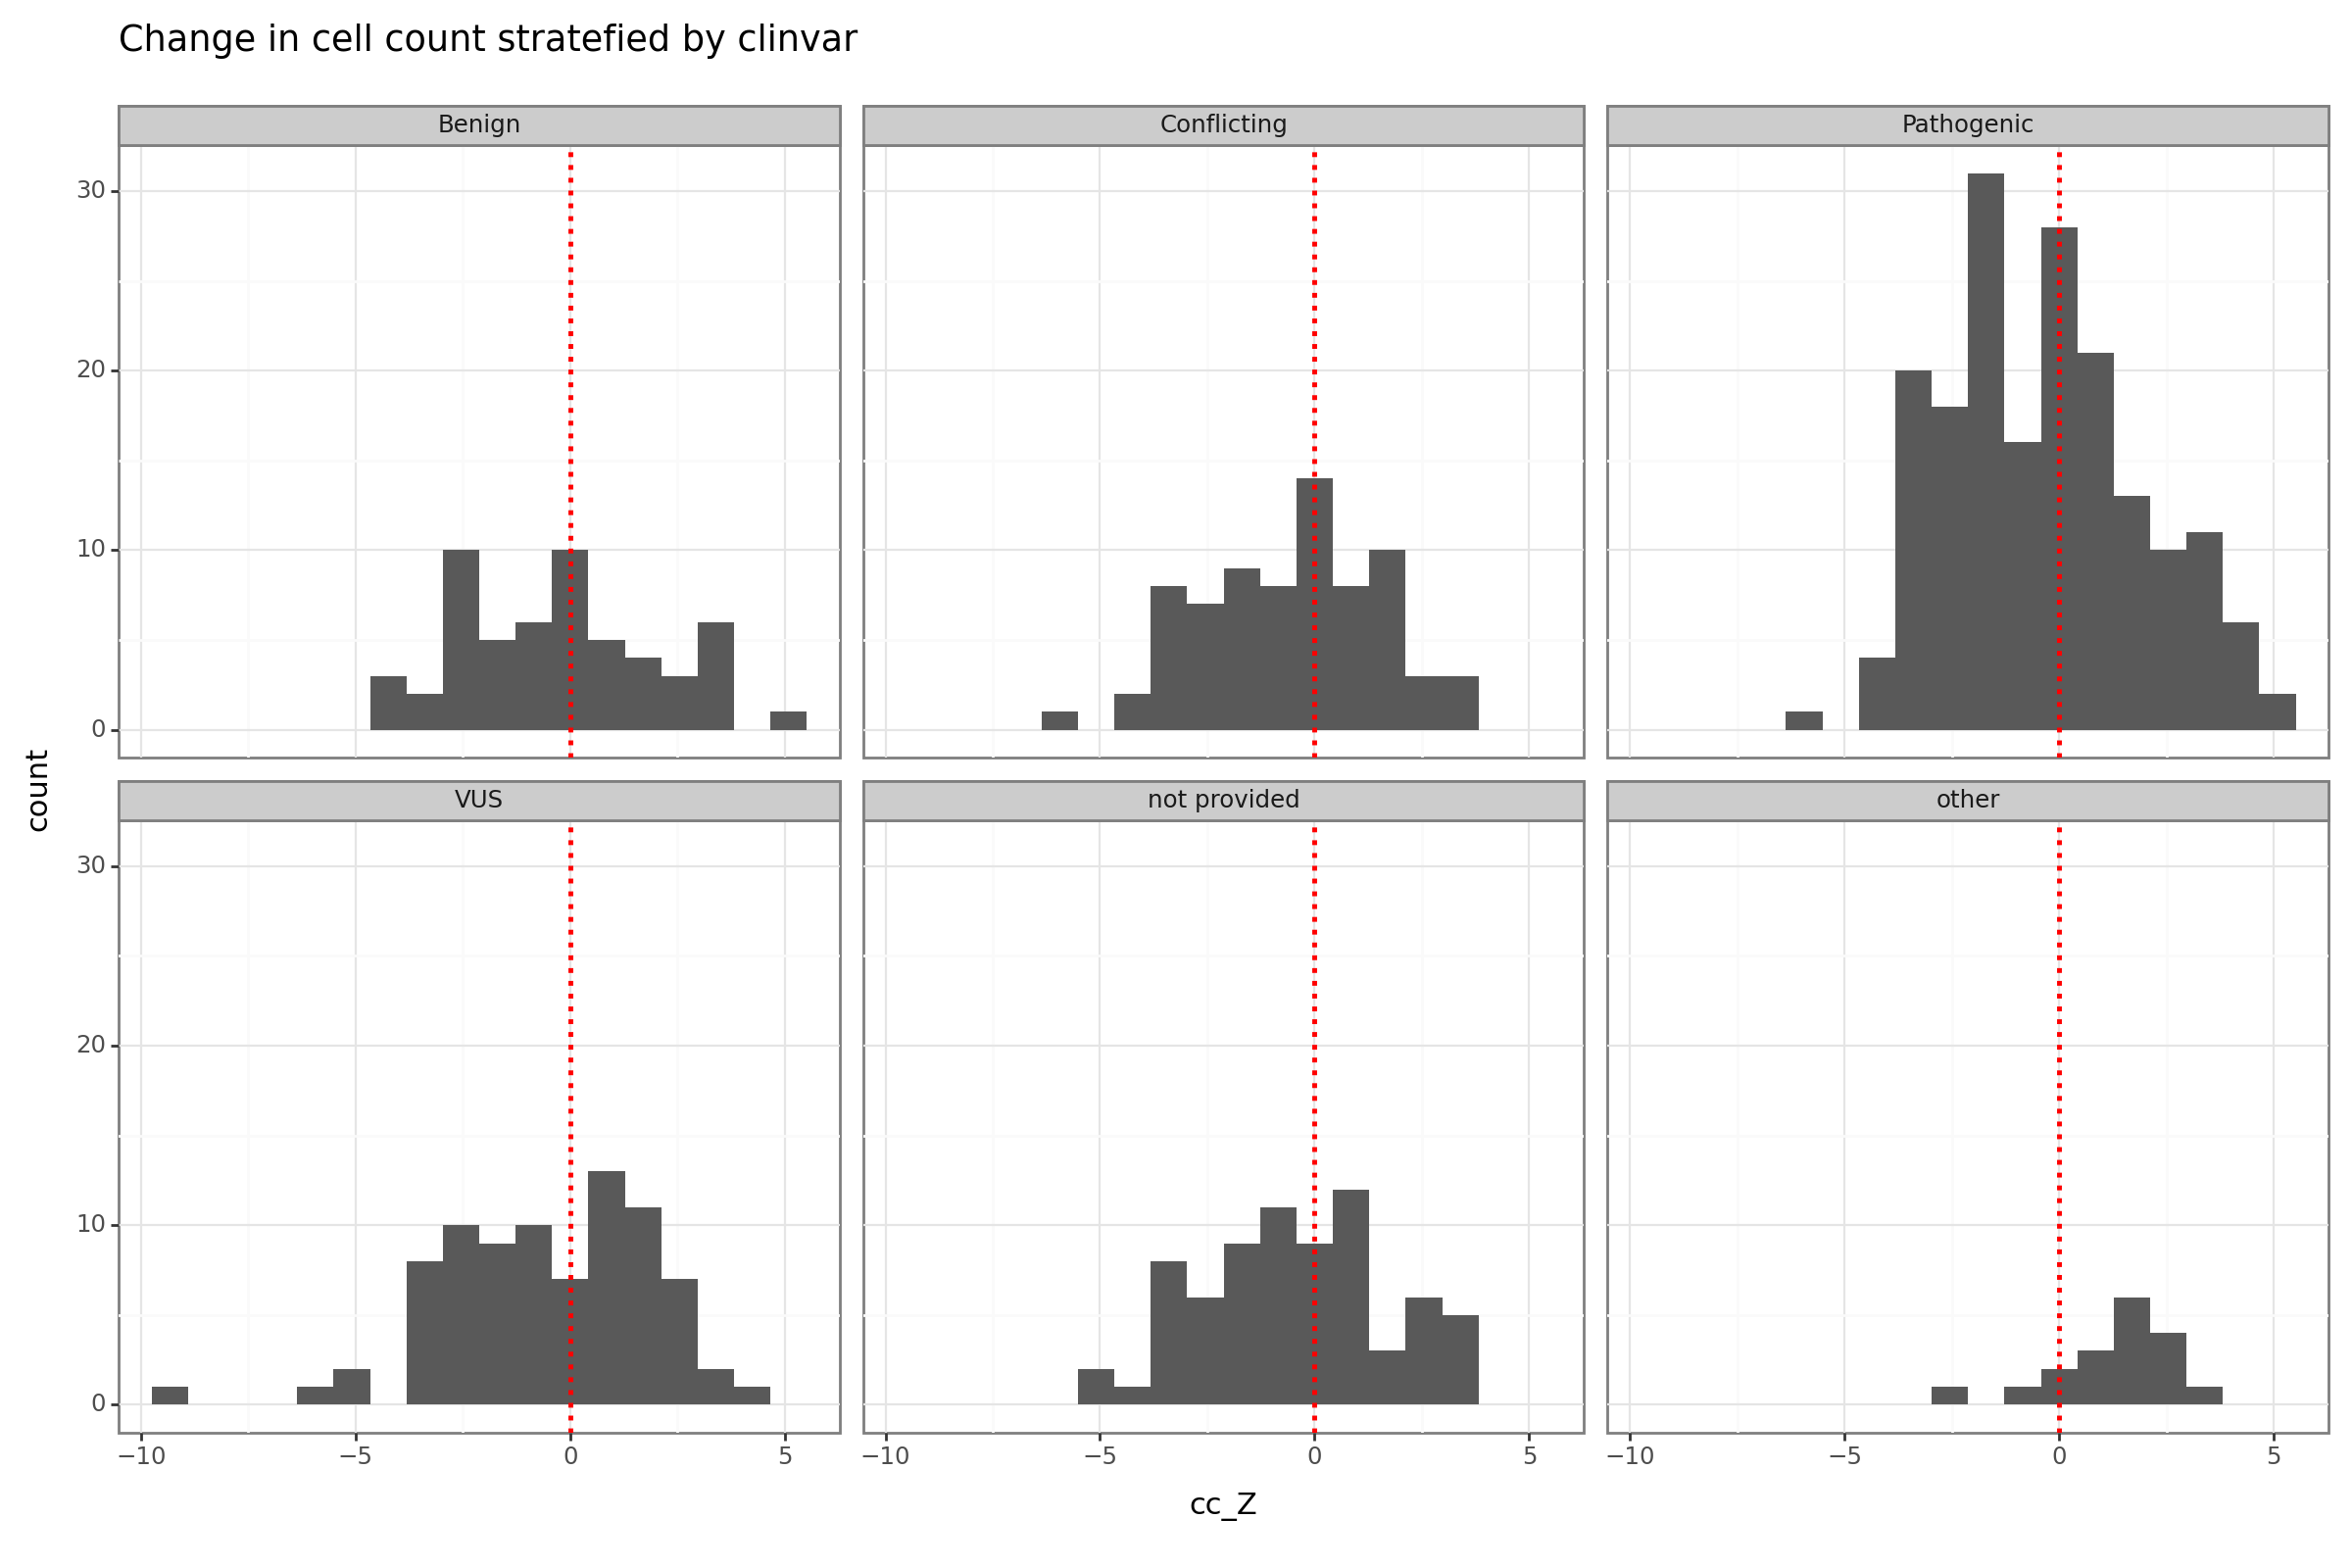

In [6]:
from plotnine import aes, geom_histogram, ggplot, theme_bw, labs, facet_wrap, geom_vline
import plotnine as plotnine

plotnine.options.figure_size = (12, 8)
plot1 = (
    ggplot(
        cc_stats,
        aes(x="cc_Z"),
    )
    + geom_histogram()
    + facet_wrap("clinvar_cs")
    + geom_vline(xintercept=0, color="red", linetype="dotted", size=1)
    + theme_bw()
    + labs(title="Change in cell count stratefied by clinvar")
)
print(plot1)